This notebook implements data preprocessing for DistilBERT,  following best practices based on the work by Pota et al. (2021), who performed a multilingual evaluation of preprocessing strategies for BERT-based sentiment analysis of tweets.

**Application of Prior Work:**

Their study provided key insights into how noise from URLs, mentions, emojis, hashtags, and other Twitter-specific elements can impact classification performance. Based on these findings, mentions and URLs are normalized into placeholders, while hashtags, emojis, and emoticons are transformed into semantically meaningful tokens.

**Addressing Limitations:**

A key limitation in prior preprocessing approaches was the lack of handling for HTML entities (e.g., "`&amp;`") which often appear in tweet text. To overcome this, a decoding step was added to ensure cleaner inputs and better semantic interpretation by the model.

**Reference:**

Pota, M., Ventura, M., Fujita, H., & Esposito, M. (2021). Multilingual evaluation of pre-processing for BERT-based sentiment analysis of tweets. *Expert Systems with Applications, 181*, 115119. https://doi.org/10.1016/j.eswa.2021.115119


In [ ]:
!pip install emot emoji wordninja

In [ ]:
import pandas as pd
import re
import html
import emoji
import wordninja
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from wordninja import split as word_split
from emot.core import emot

---
# **1. Load and Inspect the Dataset**

In [ ]:
# Load original dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/dataset.csv"
columns = ["label", "tweet"]
df = pd.read_csv(data_path, header = None, names = columns)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   100000 non-null  int64 
 1   tweet   100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                              tweet
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all.... 

label
0    50000
1    50000
Name: count, dtype: int64


In [ ]:
# Load removed dups dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/removed_dups_dataset.csv"
df1 = pd.read_csv(data_path)

# Check dataset information
print(df1.info(), "\n")
print(df1.head(), "\n")
print(df1["label"].value_counts())  # Check class distribution

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99095 entries, 0 to 99094
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   99095 non-null  int64 
 1   tweet   99095 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                              tweet
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all.... 

label
1    49683
0    49412
Name: count, dtype: int64


No oversampling is required for DistilBERT because it is a transformer-based model that uses contextual embeddings and pre-trained attention mechanisms. Unlike traditional ML models, which may struggle with class imbalance due to relying on manually engineered features, DistilBERT can effectively learn from fewer examples of the minority class. Its deep architecture and ability to generalize from pre-trained knowledge often mitigate the negative effects of class imbalance.

---
# **2. Preprocessing Tweets**

In [ ]:
# Initialize emot
emot_obj = emot()

# Function to clean text based
def clean_tweet(text):
    # Decode HTML entities (&amp; -> &)
    text = html.unescape(text)

    # Replace mentions and URLs with placeholders
    text = re.sub(r"@\w+", "[USER]", text)
    text = re.sub(r"http\S+|www\.\S+", "[URL]", text)

    # Split hashtags into separate words
    text = re.sub(r"#(\w+)", lambda m: " ".join(word_split(m.group(1))), text)

    # Replace emoticons with meanings
    emots = emot_obj.emoticons(text)
    for emo, meaning in zip(emots["value"], emots["mean"]):
        text = text.replace(emo, meaning.lower())

    # Convert emojis to words
    text = emoji.demojize(text).replace(":", "").replace("_", " ")

    return text

In [ ]:
# Apply preprocessing to original dataset
df["cleaned_tweet"] = df["tweet"].apply(clean_tweet)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   label          100000 non-null  int64 
 1   tweet          100000 non-null  object
 2   cleaned_tweet  100000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
None 

   label                                              tweet  \
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1      0  is upset that he can't update his Facebook by ...   
2      0  @Kenichan I dived many times for the ball. Man...   
3      0    my whole body feels itchy and like its on fire    
4      0  @nationwideclass no, it's not behaving at all....   

                                       cleaned_tweet  
0  [USER] [URL] - Awww, that's a bummer.  You sho...  
1  is upset that he can't update his Facebook by ...  
2  [USER] I dived many times for the ball. Manage...  
3    my whole b

In [ ]:
# Apply preprocessing to removed dups dataset
df1["cleaned_tweet"] = df["tweet"].apply(clean_tweet)

# Check dataset information
print(df1.info(), "\n")
print(df1.head(), "\n")
print(df1["label"].value_counts())  # Check class distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99095 entries, 0 to 99094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          99095 non-null  int64 
 1   tweet          99095 non-null  object
 2   cleaned_tweet  99095 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB
None 

   label                                              tweet  \
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1      0  is upset that he can't update his Facebook by ...   
2      0  @Kenichan I dived many times for the ball. Man...   
3      0    my whole body feels itchy and like its on fire    
4      0  @nationwideclass no, it's not behaving at all....   

                                       cleaned_tweet  
0  [USER] [URL] - Awww, that's a bummer.  You sho...  
1  is upset that he can't update his Facebook by ...  
2  [USER] I dived many times for the ball. Manage...  
3    my whole body fe

In [ ]:
df = df[["label", "cleaned_tweet"]]
df1 = df1[["label", "cleaned_tweet"]]

In [ ]:
# save the cleaned data in a new CSV file
df_file_path='/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/bert_cleaned_dataset.csv'
df1_file_path='/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/bert_cleaned_removed_dups_dataset.csv'
df.to_csv(df_file_path,index=False)
df1.to_csv(df1_file_path,index=False)

---
# **3. Outlier Detection**

Outlier Analysis:
- Total tweets         : 100000
- Outliers detected    : 9
- Percentage outliers  : 0.01%


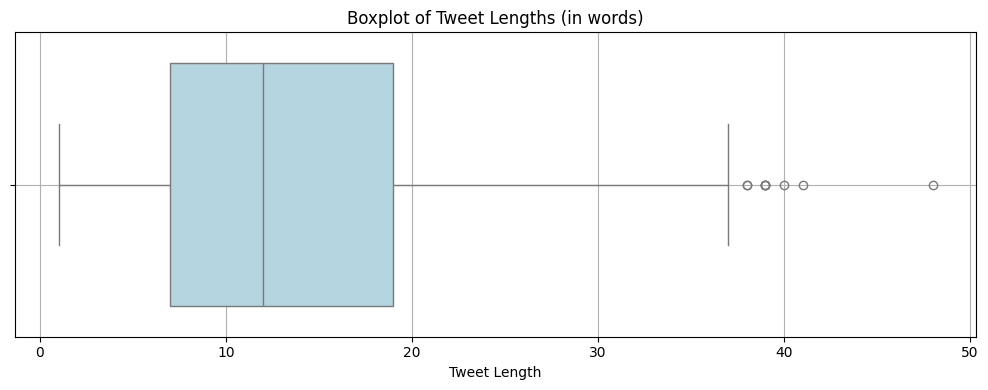

In [ ]:
# Compute tweet length (in words)
df['tweet_length'] = df['cleaned_tweet'].apply(lambda x: len(x.split()))

# Calculate IQR
Q1 = df['tweet_length'].quantile(0.25)
Q3 = df['tweet_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['tweet_length'] < lower_bound) | (df['tweet_length'] > upper_bound)]
num_outliers = outliers.shape[0]
total = df.shape[0]
percent_outliers = (num_outliers / total) * 100

# Print outlier stats
print(f"Outlier Analysis:")
print(f"- Total tweets         : {total}")
print(f"- Outliers detected    : {num_outliers}")
print(f"- Percentage outliers  : {percent_outliers:.2f}%")

# Plot boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['tweet_length'], color='lightblue')
plt.title("Boxplot of Tweet Lengths (in words)")
plt.xlabel("Tweet Length")
plt.grid(True)
plt.tight_layout()
plt.show()

Outlier Analysis:
- Total tweets         : 99095
- Outliers detected    : 9
- Percentage outliers  : 0.01%


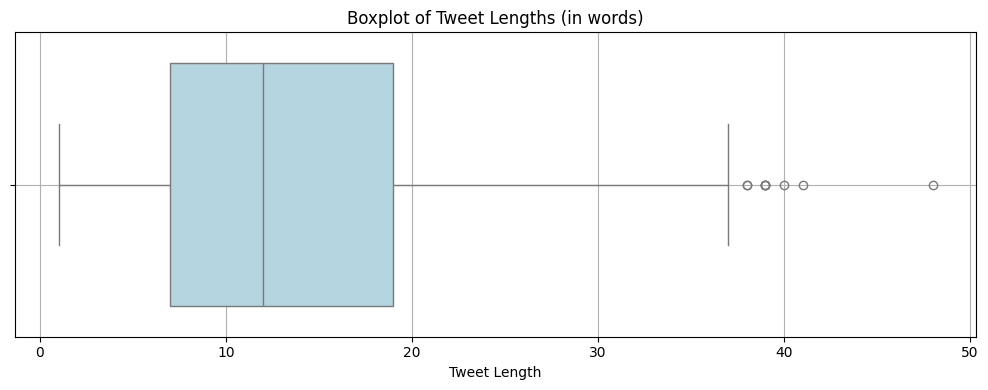

In [ ]:
# Compute tweet length (in words)
df1['tweet_length'] = df1['cleaned_tweet'].apply(lambda x: len(x.split()))

# Calculate IQR
Q1 = df1['tweet_length'].quantile(0.25)
Q3 = df1['tweet_length'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df1[(df1['tweet_length'] < lower_bound) | (df1['tweet_length'] > upper_bound)]
num_outliers = outliers.shape[0]
total = df1.shape[0]
percent_outliers = (num_outliers / total) * 100

# Print outlier stats
print(f"Outlier Analysis:")
print(f"- Total tweets         : {total}")
print(f"- Outliers detected    : {num_outliers}")
print(f"- Percentage outliers  : {percent_outliers:.2f}%")

# Plot boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=df1['tweet_length'], color='lightblue')
plt.title("Boxplot of Tweet Lengths (in words)")
plt.xlabel("Tweet Length")
plt.grid(True)
plt.tight_layout()
plt.show()

Outliers are negligible, with a percentage of as low as 0.01% (2 d.p.) of the entire dataset. Removing them will not significantly impact training. Hence, it has been decided to keep them for DistilBERT training.